In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# Q1

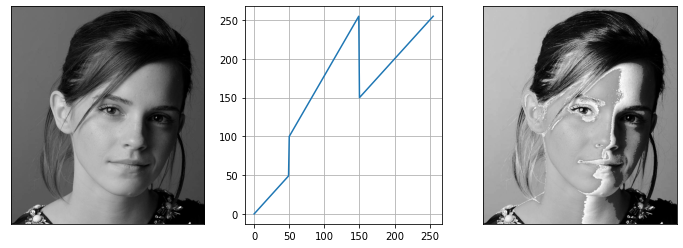

In [11]:
inp_img = cv.imread("assets/emma_gray.jpg", cv.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

t1 = np.arange(0, 50, 1)
t2 = np.linspace(100, 255, 100)
t3 = np.arange(150, 256, 1)
t = np.hstack((t1, t2, t3))

out_img = cv.LUT(inp_img, t)

ax[0].imshow(inp_img, cmap="gray")
ax[1].plot(t)
ax[2].imshow(out_img, cmap="gray")

for i in [0, 2]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
ax[1].grid(True)

plt.show()

# Q2

In [45]:
def tanh_f(x):
    num = np.exp(x) - np.exp(-x)
    den = np.exp(x) + np.exp(-x)
    return num/den

def accentuating_transformation(center, width):
    x = np.linspace(center-width, center+width, 256)
    tanh = tanh_f(x)
    max_val = np.max([np.max(tanh), np.abs(np.min(tanh))])
    scaled_tanh = tanh/max_val*127.5
    shifted_tanh = scaled_tanh + 127.5
    
    return shifted_tanh


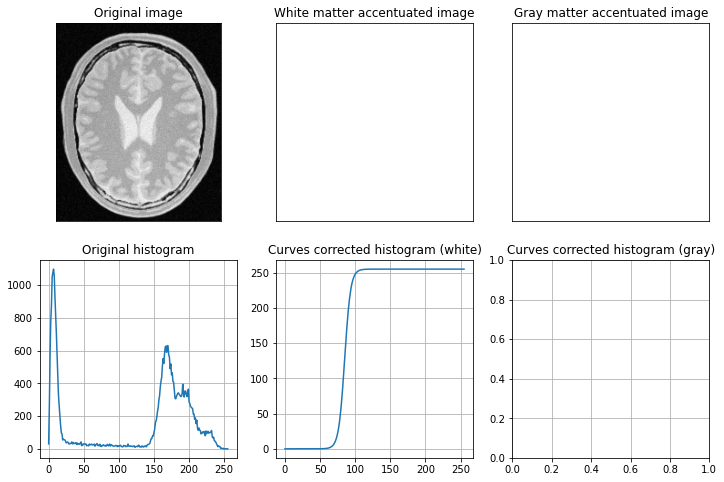

In [46]:
inp_img = cv.imread("assets/brain_proton_density_slice.png")

orig_hist = cv.calcHist([inp_img], [0], None, [256], [0,256])

white_trans = accentuating_transformation(5, 15)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

ax[0][0].imshow(inp_img)
ax[1][0].plot(orig_hist)
ax[1][1].plot(white_trans)

for i in range(3):
    ax[0][i].set_xticks([])
    ax[0][i].set_yticks([])
    ax[1][i].grid(True)

ax[0][0].set_title("Original image")
ax[0][1].set_title("White matter accentuated image")
ax[0][2].set_title("Gray matter accentuated image")
ax[1][0].set_title("Original histogram")
ax[1][1].set_title("Curves corrected histogram (white)")
ax[1][2].set_title("Curves corrected histogram (gray)")

plt.show()